In [1]:
%matplotlib inline

In [2]:
import networkx as nx
import numpy as np

from matplotlib.patches import Polygon

import pandas as pd

import matplotlib.pyplot as plt

In [3]:
def get_row_edges(df_nodes):
    frames = []
    for i, df_i in df_nodes.groupby('row'):
        frame = pd.DataFrame([[df_i.index[k], df_i.index[k + 1],
                               df_i.row_i.iloc[k], df_i.row_i.iloc[k + 1]]
                               for k in xrange(df_i.index.shape[0] - 1)],
                              columns=['index_left', 'index_right',
                                       'column_left', 'column_right'])
        frame.insert(0, 'row', i)
        frames.append(frame)
    return pd.concat(frames)

In [4]:
def get_vertical_edges(df_nodes):
    even_rows = (df_nodes.row & 0x1 == 0)
    even_columns = (df_nodes.row_i & 0x1 == 0)
    odd_rows = (df_nodes.row & 0x1 == 1)
    odd_columns = (df_nodes.row_i & 0x1 == 1)
    
    even_row_columns = (df_nodes[even_rows & even_columns]
                        .reset_index().join(df_nodes[odd_rows & even_columns]
                                            .reset_index(), lsuffix='_top',
                                            rsuffix='_bottom'))
    
    top = df_nodes[odd_rows & odd_columns].reset_index()
    bottom = df_nodes[(df_nodes.row > 0) & even_rows & odd_columns].reset_index()
    odd_row_columns = (top.iloc[:bottom.shape[0]]
                       .join(bottom, lsuffix='_top', rsuffix='_bottom'))
    
    all_columns = pd.concat([even_row_columns, odd_row_columns])
    return all_columns.sort(all_columns.columns.values.tolist())

In [5]:
def get_edges(df_nodes):
    row_edges = get_vertical_edges(df_nodes)
    vertical_edges = get_vertical_edges(df_nodes)

    new_labels = ['source', 'target']
    labels = ['index_left', 'index_right']
    row_edges = get_row_edges(df_nodes)[labels].rename(columns=dict(zip(labels, new_labels)))
    labels = ['index_top', 'index_bottom']
    vertical_edges = get_vertical_edges(df_nodes)[labels].rename(columns=dict(zip(labels, new_labels)))
    edges = pd.concat([row_edges, vertical_edges])
    return edges.sort(edges.columns.values.tolist())

In [6]:
def get_nodes(row_count, row_length, unit_offset=.25, offset_scale=1.7):
    df_nodes = pd.DataFrame(np.arange(row_count * row_length) / row_length,
                            columns=['row'])
    df_nodes['row_i'] = df_nodes.index.values % row_length

    even_rows = (df_nodes.row & 0x1 == 0)
    odd_rows = (df_nodes.row & 0x1 == 1)
    points = (df_nodes.row_i & 0x1 == 1)

    offset = (even_rows.astype(int) * ((-2 * points) + 1) + 
              odd_rows.astype(int) * ((2 * points) - 1)) * unit_offset
    df_nodes['x'] = df_nodes.row_i
    df_nodes['y'] = (df_nodes.row + offset + unit_offset) * offset_scale
    return df_nodes 

In [7]:
def get_hex_links_a(df_nodes):
    frames = []

    for i, df_i in df_nodes.groupby('row'):
        # Left-aligned rows
        for j, k in enumerate(xrange(0, df_i.shape[0] - 2, 2)):
            hex_nodes = df_i.iloc[k:k + 3].copy()
            hex_nodes['hex_row'] = 2 * (i // 2)
            hex_nodes['hex_row_i'] = j
            frames.append(hex_nodes)

        if i > 0 and i < df_nodes.row.max():
            # "Indented" rows
            for j, k in enumerate(xrange(1, df_i.shape[0] - 2, 2)):
                hex_nodes = df_i.iloc[k:k + 3].copy()
                hex_nodes['hex_row'] = 2 *((i - 1) // 2) + 1
                hex_nodes['hex_row_i'] = j
                frames.append(hex_nodes)

    df_hex_links = (pd.concat(frames)[['hex_row', 'hex_row_i', 'row', 'row_i']]
                    .sort(['hex_row', 'hex_row_i', 'row', 'row_i']))

    df_hex_index = (df_hex_links[['hex_row', 'hex_row_i']].drop_duplicates()
                    .reset_index(drop=True).reset_index()
                    .set_index(['hex_row', 'hex_row_i']))
    return df_hex_links, df_hex_index


def get_hex_links(df_nodes):
    df_hex_links, df_hex_index = get_hex_links_a(df_nodes)
    df_hex_links['hex'] = (df_hex_links[['hex_row', 'hex_row_i']]
                           .apply(lambda row: df_hex_index.loc[row['hex_row'],
                                                               row['hex_row_i']]
                                  ['index'],
                                  axis=1))
    node_index = df_nodes.reset_index().set_index(['row', 'row_i'])['index']
    df_hex_links['node'] = (df_hex_links
                            .apply(lambda row: node_index.loc[row['row'],
                                                              row['row_i']],
                                   axis=1))
    hex_node_counts = df_hex_links.groupby('hex')['node'].count()
    # assert((hex_node_counts.max() == 1) and (hex_node_counts.min() == 1))
    return (df_hex_links[['hex', 'node', 'hex_row', 'hex_row_i']]
            .sort(['hex', 'node', 'hex_row', 'hex_row_i'])).reset_index(drop=True)

In [8]:
def get_hex_paths(df_nodes):
    df_hex_links = get_hex_links(df_nodes)
    df_hex_link_xy = df_hex_links.join(df_nodes[['x', 'y']].iloc[df_hex_links.node.values]
                                       .reset_index(drop=True)).sort(['hex', 'y', 'x'])
    df_hex_link_xy.insert(1, 'vertex_i',
                          np.tile([0, 1, 5, 2, 4, 3],
                                  df_hex_link_xy.hex.unique().shape[0]))
    return df_hex_link_xy.sort(['hex', 'vertex_i']).reset_index(drop=True)

In [302]:
TERRAIN_TYPES = pd.DataFrame(['clay', 'sheep', 'ore', 'wheat',
                              'wood', 'desert',
                              'clay_port', 'sheep_port',
                              'ore_port', 'wheat_port',
                              'wood_port', 'three_to_one_port',
                              'sea'], columns=['terrain'])

# Define default map.
DEFAULT_MAP = dict(land=(range(10, 13) + range(17, 21) + range(24, 29)
                         + range(32, 36) + range(40, 43)),
                   border=(range(2, 6) + [13, 21, 29, 36, 43]
                           + range(50, 46, -1) + [39, 31, 23, 16, 9]),
                   terrain_counts=[3, 4, 3, 4, 4, 1, 1, 1, 1, 1, 1, 4, 9])

In [303]:
def get_hexes(hex_count, map_, port_offset=0):
    hex_count = df_hex_paths.hex.unique().max() + 1
    df_hexes = pd.DataFrame(['sea'] * hex_count, index=range(hex_count),
                            columns=['terrain'])

    # Set region type of each hex based on `
    df_hexes.loc[map_['land'] + map_['border'],
                 'terrain'] = (TERRAIN_TYPES
                               .values.repeat(map_['terrain_counts']))

    df_hexes['region'] = 'sea'
    df_hexes.loc[map_['land'], 'region'] = 'land'
    df_hexes.loc[map_['border'], 'region'] = 'port'
                               
    # Assign every other border position as a *sea* tile
    # (as opposed to a *port*).
    border_terrain = df_hexes.loc[(df_hexes.region == 'port')
                                  & (df_hexes.terrain != 'sea'),
                                  'terrain'].copy()
    df_hexes.loc[map_['border'][(port_offset & 0x1)::2], ['terrain', 'region']] = 'sea'
    df_hexes.loc[df_hexes.region == 'port', 'terrain'] = border_terrain.values
    return df_hexes

In [304]:
def assign_region_hex_indexes(df_hexes, inplace=False):
    if not inplace:
        df_hexes = df_hexes.copy()
        
    df_hexes.reset_index(inplace=True)
    df_hexes.loc[df_hexes.sort(['region', 'index']).index.values,
                 'region_hex_i'] = np.arange(df_hexes.shape[0])

    region_count_prefix_sum = df_hexes.groupby('region')['terrain'].count().cumsum()
    region_count_exclusive_prefix_sum = region_count_prefix_sum.copy()
    region_count_exclusive_prefix_sum[0] = 0
    region_count_exclusive_prefix_sum[1:] = region_count_prefix_sum[:-1]

    df_hexes['region_hex_i'] -= region_count_exclusive_prefix_sum[df_hexes.region].values
    df_hexes.drop('index', axis=1, inplace=True)
    
    if not inplace:
        return df_hexes

In [305]:
def shuffle_regions(df_hexes, inplace=False):
    if not inplace:
        df_hexes = df_hexes.copy()
    df_hexes['rand'] = np.random.rand(df_hexes.shape[0])
    df_hexes['region_hex_rand_i'] = 0

    region_hex_index = np.arange(df_hexes.shape[0])
    df_hexes.loc[df_hexes.sort(['region', 'rand']).index,
                 'region_hex_rand_i'] = region_hex_index

    region_count_prefix_sum = df_hexes.groupby('region')['terrain'].count().cumsum()
    region_count_exclusive_prefix_sum = region_count_prefix_sum.copy()
    region_count_exclusive_prefix_sum[0] = 0
    region_count_exclusive_prefix_sum[1:] = region_count_prefix_sum[:-1]
    region_count_exclusive_prefix_sum

    df_hexes['region_hex_rand_i'] -= region_count_exclusive_prefix_sum[df_hexes.region].values

    for region, df_i in df_hexes.groupby('region'):
        terrain = df_i.terrain.copy()
        indexes = df_i.region_hex_rand_i.copy()
        df_hexes.loc[indexes.index, 'terrain'] = terrain.values[indexes]
        
    df_hexes.drop(['region_hex_rand_i', 'rand'], axis=1, inplace=True)

    if not inplace:
        return df_hexes

In [306]:
def plot_hex_nodes(df_nodes, axis=None):
    if axis is None:
        fig, axis = plt.subplots(figsize=(10, 10))
        
    df_nodes.plot(kind='scatter', x='x', y='y', ax=axis)

    # df_edges = get_edges(df_nodes)

    # df_edge_nodes = (df_nodes.iloc[df_edges.source].reset_index(drop=True)
                     # .join(df_nodes.iloc[df_edges.target].reset_index(drop=True),
                           # lsuffix='_source', rsuffix='_target'))

    df_hex_paths = get_hex_paths(df_nodes)

    colors = axis._get_lines.color_cycle
    color = colors.next()

    for hex_i, df_i in df_hex_paths.groupby('hex'):
        poly = Polygon(df_i[['x', 'y']].values, color=color, alpha=.5)
        axis.add_patch(poly)
        center = df_i[['x', 'y']].mean()
        axis.text(center.x, center.y, str(hex_i), ha='center', va='center')

    #for i, edge in df_edge_nodes.iterrows():
        #x = [edge['x_source'], edge['x_target']]
        #y = [edge['y_source'], edge['y_target']]
        #axis.plot(x, y)
    axis.set_aspect(True)
    return axis

In [319]:
def plot_hexes(df_nodes, df_hexes, axis=None, colorby='terrain'):
    if axis is None:
        fig, axis = plt.subplots(figsize=(8, 6))
        
    df_nodes.plot(kind='scatter', x='x', y='y', ax=axis)

    df_hex_paths = get_hex_paths(df_nodes)

    REGION_COLORS = pd.Series(['brown', 'blue', 'white'],
                              index=['land', 'sea', 'port'])
    TERRAIN_COLORS = pd.Series(['red', 'green', 'grey', 'yellow', 'brown',
                                'orange',
                                'red', 'green', 'grey', 'yellow', 'brown',
                                'white', 'blue'],
                                index=['clay', 'sheep', 'ore', 'wheat', 'wood',
                                       'desert',
                                       'clay_port', 'sheep_port','ore_port',
                                       'wheat_port', 'wood_port',
                                       'three_to_one_port', 'sea'])

    for hex_i, df_i in df_hex_paths.groupby('hex'):
        hex_info = df_hexes.iloc[hex_i]
        if colorby == 'terrain':
            color = TERRAIN_COLORS[hex_info.terrain]
        elif colorby == 'region':
            color = REGION_COLORS[hex_info.region]
        else:
            raise ValueError('Invalid hex attribute to color by.  Must be '
                             'either "terrain" or "region" (not %s)' % colorby)
        alpha = 0.2 if hex_info.region == 'port' else 0.5
        poly = Polygon(df_i[['x', 'y']].values, facecolor=color, alpha=alpha)
        axis.add_patch(poly)
        center = df_i[['x', 'y']].mean()
        axis.text(center.x, center.y, str(hex_i), ha='center', va='center')
    axis.set_aspect(True)
    return axis

In [311]:
df_nodes = get_nodes(8, 17, .165, 1.75)
df_hex_paths = get_hex_paths(df_nodes)

hex_count = df_hex_paths.hex.unique().max() + 1
df_hexes = get_hexes(hex_count, DEFAULT_MAP)
assign_region_hex_indexes(df_hexes, inplace=True)

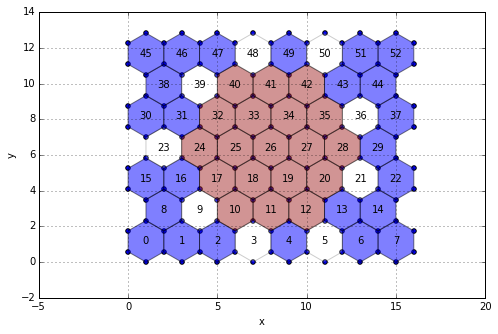

In [326]:
shuffle_regions(df_hexes, inplace=True)
fig, axis = plt.subplots(figsize=(8, 15))
plot_hexes(df_nodes, df_hexes, colorby='region', axis=axis)

In [16]:
import numpy as np

In [24]:
# get_hex_links(df_nodes)